In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import json
import pickle
import glob
from collections import defaultdict
import torch
from pymatgen import core as mg
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
import tqdm
import os
import joblib
import random
from uncertainties import ufloat
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from modules.function import pymatgen_comp, data_generator_vec, check_cuda, get_metrics
from modules.encoder import Encoder1D, EncoderDNN
from modules.representation_schemes import get_vectorized_featues, get_atomic_number_features, get_pettifor_features, get_modified_pettifor_features, get_random_features, get_random_features_dense, random_order_alpha

In [3]:
random.seed(0)
torch.manual_seed(0)

In [4]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
alternate_orders_file = 'dataset/alternate_orders.pkl'
with open(alternate_orders_file,'rb') as fid:
    alternate_order_dict = pickle.load(fid)
pettifor_order = alternate_order_dict['pettifor']
modified_pettifor_order = alternate_order_dict['modified_pettifor']
random_order = random_order_alpha

In [6]:
gfa_dataset_file = 'gfa_dataset.txt'
z_row_column_file = 'Z_row_column.txt'
element_property_file = 'element_property.txt'
common_path = "Files_from_GTDL_paper/{}" 
gfa_dataset = pickle.load(open(common_path.format(gfa_dataset_file), 'rb'))  
RC = pickle.load(open(common_path.format(z_row_column_file), 'rb')) 
new_index=[int(i[4]) for i in RC]#new order 
Z_row_column = pickle.load(open(common_path.format(z_row_column_file), 'rb'))
[property_name_list,property_list,element_name,_]=pickle.load(open(common_path.format(element_property_file), 'rb'))

In [7]:
import re

to_discard = ['Rf','Db','Sg','Bh','Hs']

def alt_read_gfa_dataset(dataset = gfa_dataset):
    str_comp = []
    Y = []
    p = []
    for i in  gfa_dataset:
        
        gfa=re.findall('\[[a-c]?\]',i)[0]
        tx1_element=re.findall('[A-Z][a-z]?', i)#[B, Fe, P,No]
        tx2_temp=re.findall('\$_{[0-9.]+}\$', i)#[$_{[50]}$, ] [50 30 20]
        tx2_value=[float(re.findall('[0-9.]+', i_tx2)[0]) for i_tx2 in tx2_temp]
        test = ''.join([x+str(y) for x,y in zip(tx1_element,tx2_value)])
        if gfa=='[c]':
            y= [0,0]
        if gfa=='[b]':
             y = [1,0]
        if gfa == '[a]': 
            y = [1,1]
        if len(set(tx1_element).intersection(set(to_discard))) == 0:
            str_comp.extend([test]*2)
            Y.extend(y)
            p.extend([0,1])
    return pymatgen_comp(str_comp),Y, p

In [8]:
saveloc = 'saved_models/Encoders'
if not os.path.exists(saveloc):
    os.makedirs(f'{saveloc}')
with open('misc/kfold.pkl','rb') as fid:
    fold_dict = pickle.load(fid)
folds = len(list(fold_dict.keys()))

In [12]:
if os.path.exists('results/representation_stats.json'):
    with open('results/representation_stats.json','rb') as fid:
        data_file = json.load(fid)
else:
    print('File does not exist!')

In [15]:
comp_gfa, y_gfa,p = alt_read_gfa_dataset()
#types = ['atomic','pettifor','mod_pettifor','random','dense']
types = ['random-tr']
order_dict = {}
sup_metrics_dict = {}
y_all = np.array(y_gfa).reshape(-1,1).astype('float32')
p_all = np.array(p).reshape(-1,1).astype('float32')
for i,k in enumerate(types):
    metrics_list = {}
    print('Representation : {}'.format(k))
    if k == 'atomic':
        comp, at_order  = get_atomic_number_features(comp_gfa)
        order_dict['atomic'] = at_order
    elif k == 'pettifor':
        comp, _  = get_pettifor_features(comp_gfa)
        order_dict['pettifor'] = pettifor_order
    elif k == 'mod_pettifor':
        comp, _  = get_modified_pettifor_features(comp_gfa)
        order_dict['mod_pettifor'] = modified_pettifor_order
    elif k == 'random':
        comp,_ = get_random_features(comp_gfa)
        order_dict['random'] = random_order
    elif k == 'random-tr':
        comp,_ = get_random_features(comp_gfa,alpha=False)
        order_dict['random'] = random_order
    elif k == 'dense':
        comp,_ = get_random_features_dense(comp_gfa, random_order)
        order_dict['random'] = random_order
    X_all = comp.astype('float32')
    
    for fold in range(folds):
        print('Fold {}'.format(fold))
        i_tr= fold_dict[fold]['train_inds']
        i_te= fold_dict[fold]['test_inds']
        X_train, X_test = X_all[i_tr], X_all[i_te]
        y_train, y_test = y_all[i_tr], y_all[i_te]
        p_train, p_test = p_all[i_tr], p_all[i_te]
        batch = 64
        Xy = [(X_train[i],y_train[i],p_train[i]) for i in range(len(y_train))]
        train_loader = DataLoader(Xy, batch_size = batch , shuffle=True)
        if k!= 'dense':
            encoder1D = Encoder1D(1,1)
        else:
            encoder1D = EncoderDNN(X_train.shape[-1],3,42,1)
        e_optimizer = optim.Adam(encoder1D.parameters(),lr = 2e-4)
        num_iterations = 2000
        cuda = check_cuda()
        if cuda:
            encoder1D = encoder1D.cuda()
        log_interval = int(5e2)
        for iter in tqdm.notebook.tqdm(range(num_iterations)):
            train_loss = 0.0
            for data in train_loader:
                X,y,p = data
                if cuda:
                    X = X.cuda()
                    y = y.cuda()
                    p = p.cuda()
                e_optimizer.zero_grad()
                target = encoder1D(X,p)
                if cuda:
                    target = target.cuda()
                e_error = torch.nn.BCELoss()(target,y)
                e_error.backward(retain_graph=True)
                e_optimizer.step()
                train_loss += e_error.cpu().item()
            if iter == 0 or (iter + 1) % log_interval == 0:  
                print('Epoch : {}, Loss : {}'.format(iter+1,train_loss))
        spec_saveloc = os.path.join(saveloc,k)
        if not os.path.exists(spec_saveloc):
            os.makedirs(f'{spec_saveloc}')
        model_scripted = torch.jit.script(encoder1D.cpu())
        model_scripted.save(os.path.join(spec_saveloc,'Encoder1D_{}_fold{}.pt'.format(k,fold)))
        if X_test.dtype != torch.float32:
            X_test = torch.from_numpy(X_test)
        if p_test.dtype != torch.float32:
            p_test = torch.from_numpy(p_test)
        y_predict = (encoder1D(X_test,p_test)).to('cpu').detach().numpy()
        metrics = get_metrics(y_test,np.round(y_predict))
        metrics_list[fold] = metrics
        print('accuracy : {},precision : {},recall : {},F1 : {}'.format(metrics[0],metrics[1],metrics[2],metrics[3]))
    sup_metrics_dict[k] = metrics_list
    updated_file = data_file|sup_metrics_dict
    with open('results/representation_stats.json','w') as f:
        json.dump(updated_file,f)

Representation : random-tr
Fold 0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.52744117379189
Epoch : 500, Loss : 41.51956319063902
Epoch : 1000, Loss : 33.382490085437894
Epoch : 1500, Loss : 29.65093112923205
Epoch : 2000, Loss : 27.473587019369006
accuracy : 0.9492,precision : 0.9494,recall : 0.9492,F1 : 0.9493
Fold 1


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 184.92027980089188
Epoch : 500, Loss : 47.721889935433865
Epoch : 1000, Loss : 37.51659085974097
Epoch : 1500, Loss : 33.24518719129264
Epoch : 2000, Loss : 29.042731983587146
accuracy : 0.9502,precision : 0.9507,recall : 0.9502,F1 : 0.9504
Fold 2


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.662113904953
Epoch : 500, Loss : 41.40961882472038
Epoch : 1000, Loss : 32.86569892056286
Epoch : 1500, Loss : 29.12355323880911
Epoch : 2000, Loss : 25.52769216056913
accuracy : 0.9396,precision : 0.941,recall : 0.9396,F1 : 0.94
Fold 3


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.796616345644
Epoch : 500, Loss : 39.34574678167701
Epoch : 1000, Loss : 31.524614587426186
Epoch : 1500, Loss : 27.293838925659657
Epoch : 2000, Loss : 24.74633719306439
accuracy : 0.9353,precision : 0.9351,recall : 0.9353,F1 : 0.9352
Fold 4


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 184.57087406516075
Epoch : 500, Loss : 43.10221294313669
Epoch : 1000, Loss : 35.39653139188886
Epoch : 1500, Loss : 31.606360072270036
Epoch : 2000, Loss : 28.884409487247467
accuracy : 0.9353,precision : 0.9386,recall : 0.9353,F1 : 0.936
Fold 5


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.63689136505127
Epoch : 500, Loss : 44.339297749102116
Epoch : 1000, Loss : 35.31958330795169
Epoch : 1500, Loss : 30.250283317640424
Epoch : 2000, Loss : 27.03798684105277
accuracy : 0.9468,precision : 0.9476,recall : 0.9468,F1 : 0.9471
Fold 6


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.88332623243332
Epoch : 500, Loss : 43.50636814534664
Epoch : 1000, Loss : 34.2111446633935
Epoch : 1500, Loss : 28.931780733168125
Epoch : 2000, Loss : 26.530265354551375
accuracy : 0.9521,precision : 0.9523,recall : 0.9521,F1 : 0.9522
Fold 7


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.86585348844528
Epoch : 500, Loss : 45.96494122222066
Epoch : 1000, Loss : 35.37571522593498
Epoch : 1500, Loss : 30.15657110698521
Epoch : 2000, Loss : 27.819719141349196
accuracy : 0.9459,precision : 0.9459,recall : 0.9459,F1 : 0.9459
Fold 8


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 187.03645503520966
Epoch : 500, Loss : 44.95496080443263
Epoch : 1000, Loss : 35.982049683108926
Epoch : 1500, Loss : 31.839947324246168
Epoch : 2000, Loss : 29.056600335985422
accuracy : 0.9487,precision : 0.9488,recall : 0.9487,F1 : 0.9488
Fold 9


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 185.27419820427895
Epoch : 500, Loss : 43.39828921109438
Epoch : 1000, Loss : 33.90853646211326
Epoch : 1500, Loss : 29.607814209535718
Epoch : 2000, Loss : 26.591716636903584
accuracy : 0.9415,precision : 0.9412,recall : 0.9415,F1 : 0.9411


In [16]:
for key in updated_file.keys():
    specific_dict = updated_file[key]
    col_names = ['Accuracy','Precision','Recall','F1 Score']
    stat_df = pd.DataFrame.from_dict(specific_dict,orient='index',columns=col_names)
    mean_stats, std_stats = stat_df.values.mean(axis=0), stat_df.values.std(axis=0)
    best_ind = np.argwhere(stat_df['F1 Score'].values == np.max(stat_df['F1 Score'])).item()
    vals = [ufloat(np.round(mean_stats[i],3), np.round(std_stats[i],3)) for i in range(len(mean_stats))]
    print('{} \nAccuracy : {}, \nPrecision : {}, \nRecall : {}, \nF1 Score : {}'.format(key,vals[0],vals[1],vals[2],vals[3]))

ptr 
Accuracy : 0.949+/-0.005, 
Precision : 0.950+/-0.005, 
Recall : 0.949+/-0.005, 
F1 Score : 0.949+/-0.005
atomic 
Accuracy : 0.950+/-0.005, 
Precision : 0.951+/-0.005, 
Recall : 0.950+/-0.005, 
F1 Score : 0.950+/-0.005
pettifor 
Accuracy : 0.945+/-0.008, 
Precision : 0.946+/-0.008, 
Recall : 0.945+/-0.008, 
F1 Score : 0.945+/-0.008
mod_pettifor 
Accuracy : 0.947+/-0.006, 
Precision : 0.948+/-0.006, 
Recall : 0.947+/-0.006, 
F1 Score : 0.948+/-0.006
random 
Accuracy : 0.940+/-0.007, 
Precision : 0.941+/-0.007, 
Recall : 0.940+/-0.007, 
F1 Score : 0.940+/-0.007
dense 
Accuracy : 0.947+/-0.006, 
Precision : 0.948+/-0.006, 
Recall : 0.947+/-0.006, 
F1 Score : 0.947+/-0.006
random-tr 
Accuracy : 0.944+/-0.006, 
Precision : 0.945+/-0.005, 
Recall : 0.944+/-0.006, 
F1 Score : 0.945+/-0.006


In [9]:
with open('results/representation_stats.json','r') as f:
        sup_metrics_dict = json.load(f)

In [10]:
import shutil
saveloc = 'saved_models/Encoders'
best_model_loc = 'saved_models/best_models'
if not os.path.exists(best_model_loc):
    os.makedirs(f'{best_model_loc}')
for key in list(sup_metrics_dict.keys()):
    if key != 'ptr':
        col_names = ['Accuracy','Precision','Recall','F1 Score']
        stat_df = pd.DataFrame.from_dict(sup_metrics_dict[key],orient='index',columns=col_names)
        spec_saveloc = os.path.join(saveloc,key)
        best_ind = np.argwhere(stat_df['F1 Score'].values == np.max(stat_df['F1 Score'])).item()
        best_model_name = sorted(os.listdir(spec_saveloc))[best_ind]
        shutil.copy(os.path.join(spec_saveloc,best_model_name), os.path.join(best_model_loc,'1DEncoder_{}.pt'.format(key))) 

/tmp/ipykernel_1832029/2445820254.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(names, rotation=45)
/tmp/ipykernel_1832029/2445820254.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(names, rotation=45)
/tmp/ipykernel_1832029/2445820254.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(names, rotation=45)
/tmp/ipykernel_1832029/2445820254.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(names, rotation=45)


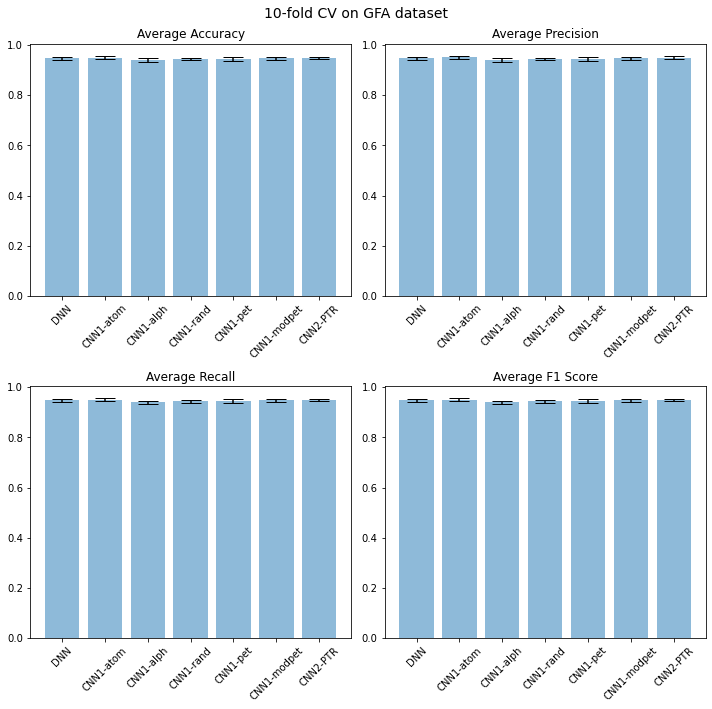

In [11]:
col_names = ['Accuracy','Precision','Recall','F1 Score']
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','ptr']
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
with open('results/representation_stats.json','rb') as fid:
        data_file = json.load(fid)
mean_list = []
std_list = []
for i, k in enumerate(methods):
        stat_arr = np.array(list(data_file[k].values()))
        mean_list.append(stat_arr.mean(axis=0))
        std_list.append(stat_arr.std(axis=0))
mean_list = np.array(mean_list).T
std_list = np.array(std_list).T
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.ravel()
for i, k in enumerate(col_names):
        ax[i].bar(methods, mean_list[i], yerr = std_list[i],align='center', alpha=0.5, ecolor='black', capsize=10)
        ax[i].set_title('Average {}'.format(k))
        ax[i].set_xticklabels(names, rotation=45)

fig.suptitle('10-fold CV on GFA dataset', fontsize = 14)
plt.tight_layout()

## Statistical significance

In [59]:
from modules.function import PTR 
def get_1D_features_gfa(k:str):
    comp_gfa, y, p = alt_read_gfa_dataset()
    y = np.array(y).reshape(-1,1).astype('float32')
    p = np.array(p).reshape(-1,1).astype('float32')
    if k not in ['atomic','pettifor','mod_pettifor','random','random-tr']:
        print('Unsupported format')
        return None, None, None
    else:
        if k == 'atomic':
            comp, at_order  = get_atomic_number_features(comp_gfa)
        elif k == 'pettifor':
            comp, _  = get_pettifor_features(comp_gfa)
        elif k == 'mod_pettifor':
            comp, _  = get_modified_pettifor_features(comp_gfa)
        elif k == 'random':
            comp,_ = get_random_features(comp_gfa)
        elif k == 'random-tr':
            comp,_ = get_random_features(comp_gfa,alpha = False)
        return comp, y, p

def get_dense_features_gfa():
    comp_gfa, y, p = alt_read_gfa_dataset()
    y = np.array(y).reshape(-1,1).astype('float32')
    p = np.array(p).reshape(-1,1).astype('float32') 
    comp,_ = get_random_features_dense(comp_gfa, random_order)
    return comp, y, p

def get_ptr_features_gfa(gfa_dataset=gfa_dataset):

    gfa_i=[]
    gfa_a=[]
    gfa_b=[]
    gfa_c=[]
    to_discard = ['Rf','Db','Sg','Bh','Hs']
    for i in  gfa_dataset:
        tx_gfa=re.findall('\[[a-c]?\]', i)
        tx1_element=re.findall('[A-Z][a-z]?', i)#[B, Fe, P,No]
        if len(set(tx1_element).intersection(set(to_discard))) == 0:      
            gfa_i.extend(tx_gfa)
            if tx_gfa[0]=='[a]':
                gfa_a.append(gfa_dataset.index(i))
            elif tx_gfa[0]=='[b]':
                gfa_b.append(gfa_dataset.index(i)) 
            else:
                gfa_c.append(gfa_dataset.index(i))
        
    gfa_data_form=[]
    gfa_data_form_p = []
    gfa_data_form_b=[]

#------------------------------------------------------------------------------
#map raw data to 2-D image using PTR
    for i in gfa_a:
        x,p,y = PTR(gfa_dataset[i])
        gfa_data_form=gfa_data_form+x
        gfa_data_form_p = gfa_data_form_p+p
        gfa_data_form_b=gfa_data_form_b+y
    for i in gfa_c:
        x,p,y = PTR(gfa_dataset[i])
        gfa_data_form=gfa_data_form+x
        gfa_data_form_p = gfa_data_form_p+p
        gfa_data_form_b=gfa_data_form_b+y 
    for i in gfa_b:
        x,p,y = PTR(gfa_dataset[i])
        gfa_data_form=gfa_data_form+x
        gfa_data_form_p = gfa_data_form_p+p
        gfa_data_form_b=gfa_data_form_b+y

    X_all = np.array(gfa_data_form).reshape(-1, 1,9, 18).astype('float32') 
    y_all = np.array(gfa_data_form_b).reshape(-1,1).astype('float32')
    p_all = np.array(gfa_data_form_p).reshape(-1,1).astype('float32')
    return X_all, y_all, p_all

In [61]:
import glob
from sklearn.metrics import mean_squared_error
best_model_loc= 'saved_models/Encoders'
best_models = glob.glob(f'{best_model_loc}/*')
prediction_dict = {}
for bm  in best_models:
    model_type = bm.split('/')[-1]
    fold_models = glob.glob(f'{bm}/*')
    if model_type in ['pettifor','atomic','random','mod_pettifor','random-tr']:
        comp_gfa, y, p  = get_1D_features_gfa(model_type)
    elif model_type == 'PTR':
        comp_gfa, y, p  = get_ptr_features_gfa()
    elif model_type == 'dense':
        comp_gfa, y, p  = get_dense_features_gfa()
    comp_gfa = torch.from_numpy(comp_gfa)
    p = torch.from_numpy(p)
    model_predictions = {}
    for i,fm in enumerate(fold_models):
        yes =[]
        model = torch.jit.load(fm)
        with torch.no_grad():
            model_predict = model(comp_gfa,p)
        for j, pred in enumerate(model_predict):
            if torch.round(pred).item() == y[j].item():
                yes.append(1)
            else:
                yes.append(0)
        model_predictions[i] = yes
    prediction_dict[model_type] = model_predictions
    #print(model_type,mean_squared_error(model_predict,y))

In [62]:
from itertools import combinations
from statsmodels.stats.contingency_tables import mcnemar
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
compare_keys = list(combinations(methods,2))
zero_sup = np.eye(len(methods))
for j in range(10):
    zero = np.eye(len(methods))
    for key in compare_keys:
        contengency = np.zeros((2,2))
        a,b = key
        cl_met1 = prediction_dict[a][j]
        cl_met2 = prediction_dict[b][j]
        ind1 = np.argwhere(np.array(methods)==a)
        ind2 = np.argwhere(np.array(methods)==b)
        for i in range(len(cl_met1)):
            if cl_met1[i] == cl_met2[i]== 1:
                contengency[0,0] +=1
            elif (cl_met1[i] == 1)*(cl_met2[i] == 0):
                contengency[0,1] += 1
            elif (cl_met1[i] == 0)*(cl_met2[i] == 1):
                contengency[1,0] += 1
            elif cl_met1[i] == cl_met2[i]== 0:
                contengency[1,1] += 1
        result = mcnemar(contengency, exact=True)
        alpha = 0.05
        zero[ind1,ind2] = result.pvalue
    zero_sup += zero
zero = np.round(zero_sup/np.max(zero_sup),2)

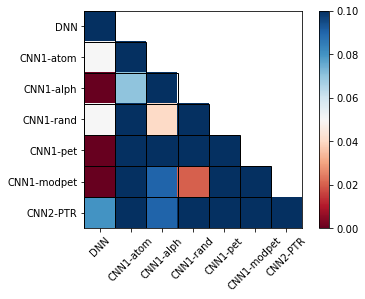

In [63]:
from matplotlib import cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
mask =  np.tri(zero.T.shape[0], k=-1)
A = np.ma.array(zero, mask=mask).T
truth = np.where(mask == 1)

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xticks(np.arange(0, len(methods), 1))
ax1.set_yticks(np.arange(0, len(methods), 1))
# use dir(matplotlib.cm) to get a list of the installed colormaps
# the "_r" means "reversed" and accounts for why zero values are plotted as white
cmap = cm.get_cmap('RdBu')

#norm = MidPointNorm(midpoint=)
#cmap.set_bad('w')
plt.imshow(A, cmap = cmap, vmin = 0, vmax = 0.1)
for i in range(len(truth[0])):
    highlight_cell(truth[1][i],truth[0][i])
diag = [0,1,2,3,4,5]
for k in diag:
    highlight_cell(k,k)
ax1.set_xticklabels(names, rotation = 45)
ax1.set_yticklabels(names)
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.colorbar()


In [ ]:
results_dict_loc = 'results/results.json'
if os.path.exists(results_dict_loc):
    with open(results_dict_loc,'r') as fid:
        sup_results_dict = json.load(fid)
    temp_dict = {}
    temp_dict['mcnemar_gfa'] = {'names' : names, 'p_vals' : zero.tolist()}
    sup_results_dict = sup_results_dict|temp_dict
    with open(results_dict_loc,'w') as fid:
        json.dump(sup_results_dict,fid)
else:
    sup_results_dict = {}
    sup_results_dict['mcnemar_gfa'] = {'names' : names, 'p_vals' : zero.tolist()}
    with open(results_dict_loc,'w') as fid:
        json.dump(sup_results_dict,fid)


In [52]:
from tabulate import tabulate
print(tabulate(zero.T, tablefmt="latex", floatfmt=".2f"))

\begin{tabular}{rrrrrrr}
\hline
 1.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
 0.05 & 1.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
 0.00 & 0.07 & 1.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
 0.05 & 0.12 & 0.04 & 1.00 & 0.00 & 0.00 & 0.00 \\
 0.00 & 0.10 & 0.12 & 0.14 & 1.00 & 0.00 & 0.00 \\
 0.00 & 0.17 & 0.09 & 0.02 & 0.12 & 1.00 & 0.00 \\
 0.08 & 0.31 & 0.09 & 0.23 & 0.12 & 0.18 & 1.00 \\
\hline
\end{tabular}
